In [2]:
# ! pip install spark
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
# !pip install pyspark
from pyspark.sql import SparkSession

In [3]:
spark = (
    SparkSession.builder.appName("Car Price Prediction").getOrCreate()
)

In [4]:
car_price = (
    spark.read.format("csv")
    .option("header",  True)
    .load("CarPrice_Assignment.csv")
)

In [5]:
car_price.toPandas().head()
# sns.pairplot(car_price.toPandas())
# plt.show()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


In [6]:
car_price.printSchema()

root
 |-- car_ID: string (nullable = true)
 |-- symboling: string (nullable = true)
 |-- CarName: string (nullable = true)
 |-- fueltype: string (nullable = true)
 |-- aspiration: string (nullable = true)
 |-- doornumber: string (nullable = true)
 |-- carbody: string (nullable = true)
 |-- drivewheel: string (nullable = true)
 |-- enginelocation: string (nullable = true)
 |-- wheelbase: string (nullable = true)
 |-- carlength: string (nullable = true)
 |-- carwidth: string (nullable = true)
 |-- carheight: string (nullable = true)
 |-- curbweight: string (nullable = true)
 |-- enginetype: string (nullable = true)
 |-- cylindernumber: string (nullable = true)
 |-- enginesize: string (nullable = true)
 |-- fuelsystem: string (nullable = true)
 |-- boreratio: string (nullable = true)
 |-- stroke: string (nullable = true)
 |-- compressionratio: string (nullable = true)
 |-- horsepower: string (nullable = true)
 |-- peakrpm: string (nullable = true)
 |-- citympg: string (nullable = true)
 |

In [7]:
numeric_columns = ["wheelbase",	"carlength",	"carwidth",	"carheight",	"curbweight",	
                  	"enginesize",	"boreratio",	"stroke",	"compressionratio",	"horsepower",	"peakrpm",	"citympg",	"highwaympg","price"]
      

In [8]:
from pyspark.sql.functions import col
numeric_feature = car_price.select([col(c).cast("float") for c in numeric_columns ])

In [9]:
features = {}
for i in numeric_columns:
  features[i] = numeric_feature.stat.corr("price", i)
  print( "Correlation to MV for ",i,numeric_feature.stat.corr("price", i))


Correlation to MV for  wheelbase 0.577815609013954
Correlation to MV for  carlength 0.6829200061793368
Correlation to MV for  carwidth 0.7593252732789826
Correlation to MV for  carheight 0.11933627096290873
Correlation to MV for  curbweight 0.8353048796203731
Correlation to MV for  enginesize 0.8741448022848783
Correlation to MV for  boreratio 0.5531732639743967
Correlation to MV for  stroke 0.07944309329818429
Correlation to MV for  compressionratio 0.06798351616221464
Correlation to MV for  horsepower 0.8081388231007026
Correlation to MV for  peakrpm -0.0852671497816066
Correlation to MV for  citympg -0.6857513366309157
Correlation to MV for  highwaympg -0.6975990921640883
Correlation to MV for  price 1.0


In [32]:
from pyspark.ml.feature import VectorAssembler
numeric_columns = ["wheelbase",	"carlength",	"carwidth",	"carheight",	"curbweight",	
                  	             "enginesize",	"boreratio",	"stroke",	"compressionratio",	"horsepower",	
                                 "peakrpm",	"citympg",	"highwaympg"]
      
vectorAssembler = VectorAssembler(inputCols = numeric_columns, outputCol = 'features')
car_price = vectorAssembler.transform(numeric_feature)
car_price = car_price.select(['features', 'price'])
"Visualization of data on Tableau, It's not nomarlize data, you must to transform it will be normalize"
"Before applying for model"
from pyspark.ml.feature import Normalizer
nomalizer = Normalizer(inputCol = "features", outputCol = "normFeatures", p = 1.0)
nomalizer_data = nomalizer.transform(car_price)
nomalizer_data

DataFrame[features: vector, price: float, normFeatures: vector]

In [35]:
# nomalizer_data.show()
splits = nomalizer_data.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [150]:
# I would suggest if you are concerned about the value to do some search over the space of values for regParam, 
# using a held-out validation set L2

# Linear regression with combined L1 and L2 priors as regularizer.
#  elasticNetParam corresponds to α and regParam corresponds to λ.

# PySpark's Logistic regression accepts an elasticNetParam parameter. 
# If I set this parameter to let's say 0.2, what does it mean? Does it mean 0.2 of l1 and0.8 of l2 or is it the other way around
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = "features", labelCol = "price", 
                      maxIter = 100, regParam =0.3, elasticNetParam  = 0.8)
lr_model = lr.fit(train_df)

In [148]:
print("Coefficients: "+ str(lr_model.coefficients))
print("Intercept: "+ str(lr_model.intercept))

Coefficients: [105.29476712696139,-143.19603422958625,834.3868690453648,278.812809458785,1.8394111604242793,110.1338654165954,-222.33395442753488,-2999.4988596810986,255.93825638908226,39.16020678681065,2.862411069369122,-216.84900379700176,151.3154403980206]
Intercept: -71031.64094107386


In [149]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 3046.115212
r2: 0.856332


In [83]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)
#  3586.61

Root Mean Squared Error (RMSE) on test data = 3594.76


In [84]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
y = trainingSummary.residuals.toPandas()


numIterations: 100
objectiveHistory: [0.5, 0.3947630858795445, 0.18416181691035927, 0.10713692702937844, 0.10264058590405473, 0.07964394517745466, 0.07496116786301371, 0.07431182163470845, 0.07262894617916342, 0.07229438329129913, 0.07189868228339404, 0.07167290537982474, 0.07162558093001044, 0.07123013575658473, 0.07112341742182032, 0.07072922996473383, 0.0705718707534808, 0.07036103591571104, 0.0701559364419395, 0.06999924915983545, 0.0699337920313842, 0.06987211210466923, 0.06984191246747319, 0.06981238011284206, 0.06979511437291547, 0.06977414777212985, 0.06976518830241436, 0.06975965461480269, 0.06972404992315957, 0.06970035555309698, 0.0696825154600035, 0.0696379520675414, 0.06960570403496384, 0.06949588425465221, 0.06895144995486073, 0.06894098515735474, 0.06891920335017473, 0.06890987989787808, 0.06890730734981562, 0.06888989658302201, 0.06887828229619022, 0.06886736480876297, 0.068852372679922, 0.06884416400571745, 0.06883955742228615, 0.06882896752420654, 0.06882532117046798,

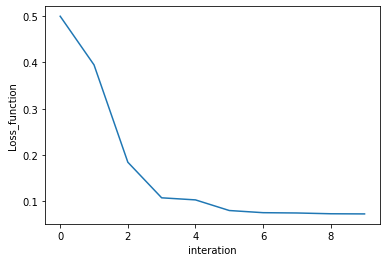

In [85]:
x = [i for i in range(10)]
y = trainingSummary.objectiveHistory
loss = pd.DataFrame([x, y]).T
loss.columns = ["interation", "Loss_function"]
sns.lineplot(x = "interation", y = "Loss_function", data = loss)

In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import ensemble
from sklearn.linear_model import Lasso,Ridge

In [118]:
from pyspark.sql.functions import col
data = numeric_feature.toPandas()
# data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,0:-1], data.iloc[:,-1], test_size=0.2 )

In [123]:
from sklearn.preprocessing import Normalizer
nomalizer = Normalizer()
x_train_minmax = nomalizer.fit_transform(x_train)
x_test_minmax = nomalizer.fit_transform(x_test)

In [125]:

# Bulding and fitting the Linear Regression model
linearModel = LinearRegression()
linearModel.fit(x_train, y_train)
  
# Evaluating the Linear Regression model
print(linearModel.score(x_test, y_test))

0.7279512881916474


In [131]:
rr100 = Ridge(alpha=0.2) #  comparison with alpha value
rr100.fit(x_train, y_train)
Ridge_test_score100 = rr100.score(x_test, y_test)
Ridge_test_score100

0.7278375506808094

In [151]:
lasso001 = Lasso(alpha=0.03, max_iter=10e5)
lasso001.fit(x_train,y_train)
coeff_used = np.sum(lasso001.coef_!=0)

print(coeff_used)

13
